In [1]:
# for data manipulation
import pandas as pd
import numpy as np

# for plotting/visualising the distibution of data
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly import tools

import random
import re

# for pre-processing of the data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
from sklearn.linear_model import LinearRegression
import patsy

## Importing the IRS, Access and Restaurants(from food atlas), life expectancy and mortality rate datasets for analysis

In [2]:
health_irs = pd.read_csv("health_irs.csv")
access = pd.read_csv("access.csv")
life = pd.read_csv('life_exp.csv')
mort = pd.read_csv('mort_rate.csv')
rest = pd.read_csv('restaran.csv')

## Extracting out the required features for analysis from raw data

In [3]:
# features from HEALTH_IRS dataset 
df1 = pd.DataFrame()
df1['FIPS'] = health_irs['FIPS']
df1['Income'] = health_irs['A02650']
df1['health_pay'] = health_irs['A09750']
df1['diab'] = ((health_irs['PCT_DIABETES_ADULTS13'] + health_irs['PCT_DIABETES_ADULTS08']) / 2)
df1['obes'] = ((health_irs['PCT_OBESE_ADULTS13'] + health_irs['PCT_OBESE_ADULTS08']) / 2)

# features from Access dataset
df2 = pd.DataFrame()
df2['FIPS'] = access['FIPS']
df2['la'] = ((access['PCT_LACCESS_POP10'] + access['PCT_LACCESS_POP15']) / 2)
df2['pchla'] = access['PCH_LACCESS_POP_10_15']
df2['hncla'] = ((access['PCT_LACCESS_HHNV10'] + access['PCT_LACCESS_HHNV15']) / 2)

# features from restaurant dataset
df3 = pd.DataFrame()
df3['FIPS'] = rest['FIPS']
df3['exp_ff'] = (rest['PC_FFRSALES07'] + rest['PC_FFRSALES12']) / 2
df3['exp_rest'] = (rest['PC_FSRSALES07'] + rest['PC_FSRSALES12']) / 2
df3['state'] = rest['State']

# merging the diffferent dataframes
dft = df2.merge(df1, on = 'FIPS')
df = pd.merge(dft, df3, on='FIPS')
df.shape
df.drop('FIPS', axis=1, inplace=True)
dfg = df.groupby(['state'], sort=False).mean()

In [4]:
mort.head()

,gnd,pctile,age_at_d,yod,lag,mortrate,hh_inc,deaths,count
0,F,1,40,2001,2,0.004409,364.823006,95,21545
1,F,1,40,2002,2,0.005786,383.668744,124,21431
2,F,1,40,2003,2,0.005046,374.732925,107,21203
3,F,1,40,2004,2,0.004787,370.528819,100,20890
4,F,1,40,2005,2,0.004725,356.143865,93,19684


In [5]:
print(df1.shape)
print(df2.shape)
print(df3.shape)

(3018, 5)
(3143, 4)
(3143, 4)


In [6]:
df.head()

,la,pchla,hncla,Income,health_pay,diab,obes,exp_ff,exp_rest,state
0,32.915956,-5.056026,3.318059,183214.0000,52.000000,12.20,32.80,662.157044,498.331247,AL
1,18.042981,-13.204891,2.026471,267456.4783,80.652174,10.10,26.80,662.157044,498.331247,AL
2,21.473266,6.067799,4.232624,54174.1250,15.500000,16.00,41.00,662.157044,498.331247,AL
3,4.395039,-7.224696,3.140004,107697.7273,34.909091,12.95,36.30,662.157044,498.331247,AL
4,4.599110,140.568857,3.302897,204151.8750,71.687500,12.75,33.25,662.157044,498.331247,AL


In [7]:
df3['state'].unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

In [8]:
df.shape

(3018, 10)

In [9]:
life.head()

,gnd,pctile,year,count,hh_inc,le_agg,le_raceadj,sd_le_agg,sd_le_raceadj
0,F,1,2001,398740,499.10938,79.682068,79.893463,0.392838,0.385240
1,F,1,2002,411159,541.30695,79.183594,79.410622,0.353981,0.346817
2,F,1,2003,420298,529.13910,79.364410,79.572174,0.364780,0.359097
3,F,1,2004,427728,499.29950,79.898407,80.092476,0.352018,0.347992
4,F,1,2005,433665,474.14536,80.283600,80.465935,0.334612,0.330986


In [10]:
print(life.shape)
print(mort.shape)

(2800, 9)
(85400, 9)


In [11]:
life.describe()

,pctile,year,count,hh_inc,le_agg,le_raceadj,sd_le_agg,sd_le_raceadj
count,2800.000000,2800.000000,2800.000000,2.800000e+03,2800.000000,2800.000000,2800.000000,2800.000000
mean,50.500000,2007.500000,433773.845714,9.764774e+04,83.627406,83.672665,0.560205,0.550729
std,28.871226,4.031849,18872.974468,1.977964e+05,3.657129,3.600353,0.107541,0.106312
min,1.000000,2001.000000,387717.000000,1.375935e+02,67.862122,68.343384,0.179007,0.185262
25%,25.750000,2004.000000,421633.000000,3.083662e+04,81.774229,81.858478,0.494333,0.485487
50%,50.500000,2007.500000,436506.000000,6.119835e+04,84.143944,84.189407,0.560017,0.550386
75%,75.250000,2011.000000,445446.500000,1.048515e+05,86.313641,86.306168,0.624831,0.614215
max,100.000000,2014.000000,462127.000000,2.435930e+06,91.120705,91.076477,0.998827,0.974649


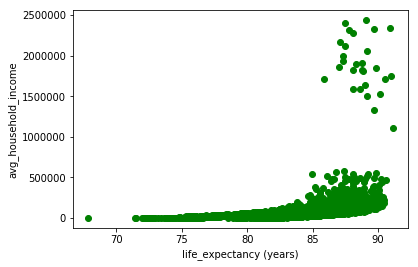

In [12]:
plt.scatter(life['le_agg'], life['hh_inc'], c='g')
plt.xlabel('life_expectancy (years)')
plt.ylabel('avg_household_income')
plt.show()

In [13]:
from scipy.stats import linregress
print(linregress(life['le_agg'], life['hh_inc']))

LinregressResult(slope=19025.20527166232, intercept=-1493380.8259447026, rvalue=0.35176392910878, pvalue=2.3777503659974395e-82, stderr=957.1306330401748)


In [14]:
mort.head()

,gnd,pctile,age_at_d,yod,lag,mortrate,hh_inc,deaths,count
0,F,1,40,2001,2,0.004409,364.823006,95,21545
1,F,1,40,2002,2,0.005786,383.668744,124,21431
2,F,1,40,2003,2,0.005046,374.732925,107,21203
3,F,1,40,2004,2,0.004787,370.528819,100,20890
4,F,1,40,2005,2,0.004725,356.143865,93,19684


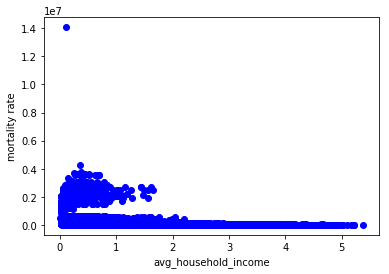

In [26]:
mort['pct_mort'] = mort['mortrate']*100
plt.scatter(mort['pct_mort'], mort['hh_inc'], c='b')
plt.ylabel('mortality rate')
plt.xlabel('avg_household_income')
plt.show()

In [16]:
from scipy.stats import linregress
print(linregress(mort['pct_mort'], mort['hh_inc']))

LinregressResult(slope=-49754.456372051616, intercept=128217.66788277449, rvalue=-0.14719222157380624, pvalue=0.0, stderr=1144.1078058164944)


In [17]:
c = mort['pct_mort'].corr(mort['hh_inc'])
print(c)

-0.14719222157380624


In [18]:
df.describe()

,la,pchla,hncla,Income,health_pay,diab,obes,exp_ff,exp_rest
count,3003.000000,2.997000e+03,3017.000000,3.018000e+03,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000
mean,23.319501,7.397223e+03,3.201271,1.890820e+05,72.289624,10.524039,29.934957,618.851148,637.645084
std,18.700723,4.033940e+05,3.132978,2.717967e+05,96.647728,2.190931,3.987959,83.663235,119.353464
min,0.000000,-1.000000e+02,0.000000,2.990000e+03,0.000000,3.150000,12.350000,383.104903,405.788252
25%,11.359432,-1.088453e+01,1.722522,3.905611e+04,15.000000,9.050000,27.850000,550.033691,554.034359
50%,19.901879,-7.318760e-02,2.630777,8.592080e+04,39.875000,10.400000,30.200000,619.273324,646.022675
75%,29.011581,7.177775e+00,3.854461,2.178854e+05,91.638889,11.950000,32.350000,678.445424,680.803467
max,100.000001,2.208376e+07,64.536399,3.626014e+06,1110.125000,20.300000,45.000000,1039.626235,2045.329455


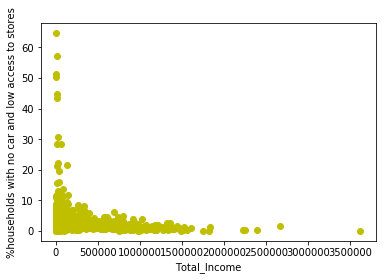

In [19]:
plt.scatter(df['Income'], df['hncla'], c='y')
plt.xlabel('Total_Income')
plt.ylabel('%households with no car and low access to stores')
plt.show()

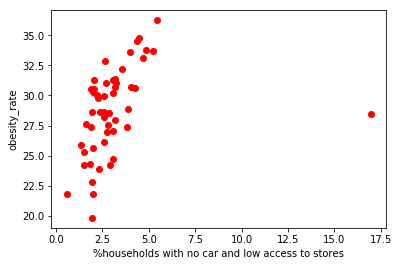

In [21]:
#df['diab'] = df['diab']/(df['diab'].max()) #- df['diab'].min())
#df['obes'] = df['obes']/(df['obes'].max())#- df['obes'].min())
#df['health_pay'] = df['health_pay']/(df['health_pay'].max())
plt.scatter(dfg['hncla'], dfg['obes'], c='r')
plt.xlabel('%households with no car and low access to stores')
plt.ylabel('obesity_rate')
plt.show()

In [22]:
from scipy.stats import linregress
print(linregress(dfg['hncla'], dfg['obes']))

LinregressResult(slope=0.5214667208751294, intercept=27.131833848228716, rvalue=0.3208639480716306, pvalue=0.021693663035556608, stderr=0.219894856402642)


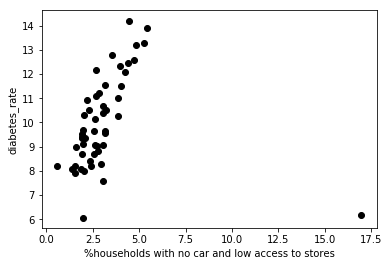

In [24]:
#df['diab'] = df['diab']/(df['diab'].max()) #- df['diab'].min())
#df['obes'] = df['obes']/(df['obes'].max())#- df['obes'].min())
#df['health_pay'] = df['health_pay']/(df['health_pay'].max())
plt.scatter(dfg['hncla'], dfg['diab'], c='k')
plt.xlabel('%households with no car and low access to stores')
plt.ylabel('diabetes_rate')
plt.show()

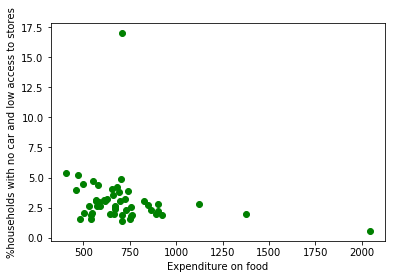

<Figure size 432x288 with 0 Axes>

In [43]:
#df['diab'] = df['diab']/(df['diab'].max()) #- df['diab'].min())
#dfg['obes'] = dfg['obes']/(dfg['obes'].max())#- df['obes'].min())
#df['health_pay'] = df['health_pay']/(df['health_pay'].max())
plt.scatter(dfg['exp_rest'], dfg['hncla'], c='g')
plt.ylabel('%households with no car and low access to stores')
plt.xlabel('Expenditure on food')
#plt.scatter(df['exp_rest'], df['diab'])
plt.show()
plt.savefig('exp.png')

In [37]:
from scipy.stats import linregress
print(linregress(dfg['hncla'], dfg['exp_rest']))

LinregressResult(slope=-23.971964582506516, intercept=786.7685982105429, rvalue=-0.2105189791039684, pvalue=0.13812517733507226, stderr=15.902704188487322)


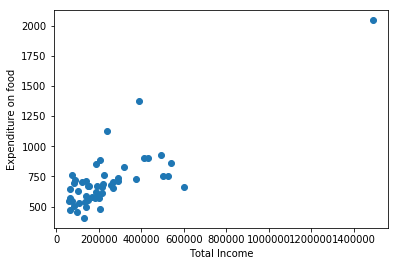

In [19]:
#df['diab'] = df['diab']/(df['diab'].max()) #- df['diab'].min())
#dfg['obes'] = dfg['obes']/(dfg['obes'].max())#- df['obes'].min())
#df['health_pay'] = df['health_pay']/(df['health_pay'].max())
plt.scatter(dfg['Income'], dfg['exp_rest'])
plt.xlabel('Total Income')
plt.ylabel('Expenditure on food')
#plt.scatter(df['exp_rest'], df['diab'])
plt.show()

In [36]:
from scipy.stats import linregress
print(linregress(dfg['exp_rest'], dfg['Income']))

LinregressResult(slope=714.1890635658184, intercept=-262572.89890424407, rvalue=0.807696820344227, pvalue=7.946830618834122e-13, stderr=74.47710930788311)


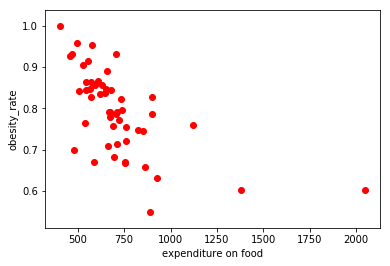

In [20]:
#df['diab'] = df['diab']/(df['diab'].max()) #- df['diab'].min())
dfg['obes'] = dfg['obes']/(dfg['obes'].max())#- df['obes'].min())
#df['health_pay'] = df['health_pay']/(df['health_pay'].max())
plt.scatter(dfg['exp_rest'], dfg['obes'], color='r')
plt.xlabel('expenditure on food')
plt.ylabel('obesity_rate')
#plt.scatter(df['exp_rest'], df['diab'])
plt.show()

In [40]:
from scipy.stats import linregress
print(linregress(dfg['obes'], dfg['exp_rest']))

LinregressResult(slope=-1550.6057477360755, intercept=1942.8582780711545, rvalue=-0.610849678402052, pvalue=1.932390218610466e-06, stderr=287.1145516233412)


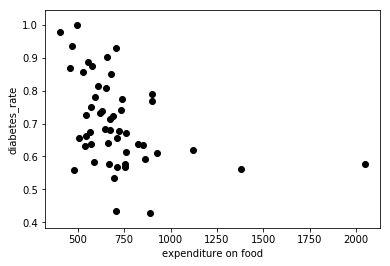

In [21]:
dfg['diab'] = dfg['diab']/(dfg['diab'].max()) #- df['diab'].min())
#plt.scatter(df['exp_rest'], df['obes'], color='r')
plt.scatter(dfg['exp_rest'], dfg['diab'], c='k')
plt.xlabel('expenditure on food')
plt.ylabel('diabetes_rate')
plt.show()

In [42]:
from scipy.stats import linregress
print(linregress(dfg['diab'], dfg['exp_rest']))

LinregressResult(slope=-755.1652309142952, intercept=1243.5540710398636, rvalue=-0.3923030035369313, pvalue=0.004409713475511987, stderr=252.94886663628978)


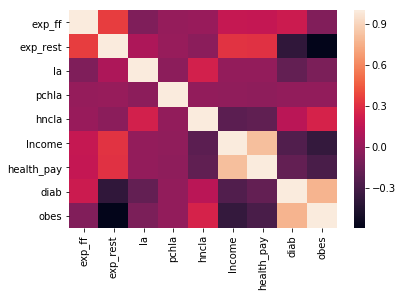

In [46]:
corrs = df.corr()
sns.heatmap(corrs, xticklabels = corrs.columns, yticklabels = corrs.columns)

In [47]:
print(corrs)

              exp_ff  exp_rest        la     pchla     hncla    Income  \
exp_ff      1.000000  0.356798 -0.078341 -0.001322  0.014111  0.179472   
exp_rest    0.356798  1.000000  0.086012  0.007291 -0.035017  0.320335   
la         -0.078341  0.086012  1.000000 -0.027756  0.240578 -0.005255   
pchla      -0.001322  0.007291 -0.027756  1.000000 -0.011660 -0.017071   
hncla       0.014111 -0.035017  0.240578 -0.011660  1.000000 -0.215295   
Income      0.179472  0.320335 -0.005255 -0.017071 -0.215295  1.000000   
health_pay  0.176618  0.312417 -0.001804 -0.021810 -0.196238  0.818193   
diab        0.204958 -0.393074 -0.181764 -0.009211  0.140951 -0.250814   
obes       -0.070929 -0.592228 -0.090704 -0.009014  0.253197 -0.373363   

            health_pay      diab      obes  
exp_ff        0.176618  0.204958 -0.070929  
exp_rest      0.312417 -0.393074 -0.592228  
la           -0.001804 -0.181764 -0.090704  
pchla        -0.021810 -0.009211 -0.009014  
hncla        -0.196238  0.140951  

In [49]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
df.dropna(axis=0, inplace=True)
y = df['obes']
x = df.drop(['diab', 'obes', 'Income'], axis=1)
model = sm.OLS(y, x)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   obes   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     6565.
Date:                Sun, 28 Oct 2018   Prob (F-statistic):               0.00
Time:                        00:49:23   Log-Likelihood:                -3709.7
No. Observations:                1208   AIC:                             7431.
Df Residuals:                    1202   BIC:                             7462.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
exp_ff         0.0611      0.001     50.763      0.0

In [121]:
df1.shape

(1219, 3)

In [122]:
df1.describe()

,FIPS,Income,diabetes
count,1219.000000,1.218000e+03,1219.000000
mean,14800.328958,1.992099e+05,11.337572
std,6828.796882,2.901721e+05,2.639538
min,1001.000000,2.990000e+03,3.300000
25%,9002.000000,3.993996e+04,9.700000
50%,17079.000000,8.917333e+04,11.400000
75%,20108.000000,2.303443e+05,13.000000
max,26065.000000,2.665477e+06,23.500000


In [123]:
df1 = df1.dropna(axis=0)

In [124]:
df1['diabetes'] = pd.cut(df1['diabetes'], bins = [0,7,25], labels = ["1", "2"])
df1['diabetes'] = df1['diabetes'].astype(int)

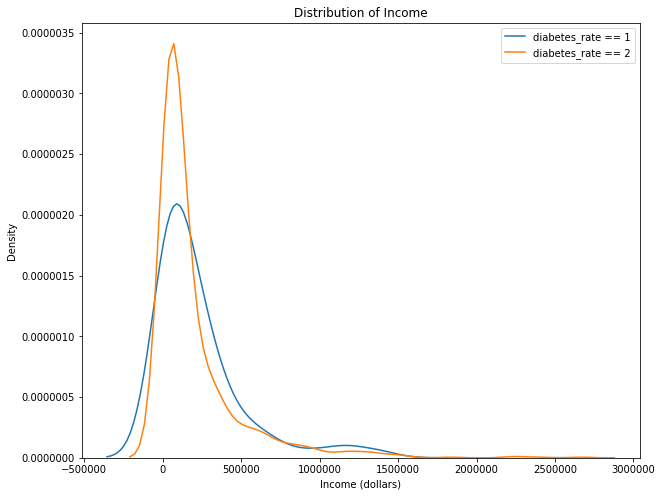

In [127]:
plt.figure(figsize = (10, 8))

df = df1[['diabetes', 'Income']]

# KDE plot of passengers who did not survive 
sns.kdeplot(df.loc[df['diabetes'] == 1, 'Income'], label = 'diabetes_rate == 1')

# KDE plot of passengers who survived
sns.kdeplot(df.loc[df['diabetes'] == 2, 'Income'], label = 'diabetes_rate == 2')

# Labeling of plot
plt.xlabel('Income (dollars)'); plt.ylabel('Density'); plt.title('Distribution of Income');

In [125]:
# Function to plot the classes of the variables
def random_color_generator(number_of_colors):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    return color

def get_percent(df, temp_col, width=800, height=500):
    cnt_srs = df[[temp_col, 'diabetes']].groupby([temp_col], as_index=False).mean().sort_values(by=temp_col)

    trace = go.Bar(
        x = cnt_srs[temp_col].values[::-1],
        y = cnt_srs['diabetes'].values[::-1],
        text = cnt_srs.values[::-1],
        textposition = 'auto',
        name = "Percent",
        textfont = dict(
            size=12,
            color='rgb(0, 0, 0)'
        ),
        orientation = 'v',
            marker = dict(
                color = random_color_generator(100),
                line=dict(color='rgb(8,48,107)',
                  width=1.5,)
            ),
            opacity = 0.7,
    )    
    return trace

def get_count(df, temp_col, width=800, height=500):
    cnt_srs = df[temp_col].value_counts().sort_index()

    trace = go.Bar(
        x = cnt_srs.index[::-1],
        y = cnt_srs.values[::-1],
        text = cnt_srs.values[::-1],
        textposition = 'auto',
        textfont = dict(
            size=0,
            color='rgb(0, 0, 0)'
        ),
        name = 'Count',
        orientation = 'v',
            marker = dict(
                color = random_color_generator(100),
                line=dict(color='rgb(8,48,107)',
                  width=1.5,)
            ),
            opacity = 0.7,
    )    
    return trace

def plot_count_percent_for_object(df, temp_col, height=400):
    trace1 = get_count(df, temp_col)
    trace2 = get_percent(df, temp_col)

    fig = tools.make_subplots(rows=1, cols=2, subplot_titles=('Count', 'Percent'), print_grid=False)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 2)

    fig['layout']['yaxis1'].update(title='Count')
    fig['layout']['yaxis2'].update(range=[0, 1], title='% diabetes_rate')
    fig['layout'].update(title = temp_col, margin=dict(l=100), width=800, height=height, showlegend=False)

    py.iplot(fig)

In [112]:
df1['Income'] = pd.cut(df1['Income'], 4, labels = ["lower", "lower_middle", "upper_middle", "upper"])


In [114]:
df1.head(15)

,FIPS,Income,diabetes
0,1001,lower,2
1,1003,lower,2
2,1005,lower,2
3,1007,lower,2
4,1009,lower,2
5,1011,lower,2
6,1013,lower,2
7,1015,lower,2
8,1017,lower,2
9,1019,lower,2


In [113]:
temp_col = df1.columns.values[2]
plot_count_percent_for_object(df1, temp_col)

ValueError: Grouper for 'diabetes' not 1-dimensional

In [72]:
df1['diabetes'].unique()

[2, 3, 1]
Categories (3, object): [1 < 2 < 3]

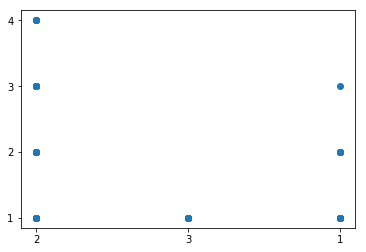

In [71]:
plt.scatter(df1['diabetes'], df1['Income'])
plt.show()

In [27]:
print(df1.head())

AttributeError: 'function' object has no attribute 'head'

In [44]:
'''df1['Income'] = df1['Income']/(df1['Income'].max() - df1['Income'].min())
df1['diabetes'] = df1['diabetes']/(df1['diabetes'].max() - df1['diabetes'].min())
print(df1.head())'''

"df1['Income'] = df1['Income']/(df1['Income'].max() - df1['Income'].min())\ndf1['diabetes'] = df1['diabetes']/(df1['diabetes'].max() - df1['diabetes'].min())\nprint(df1.head())"

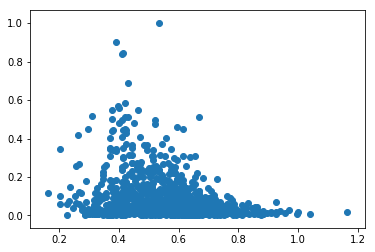

In [43]:
plt.scatter(df1['diabetes'], df1['Income'])
plt.show()

In [19]:
df2 = pd.DataFrame()
df2['FIPS'] = access['FIPS']
df2['access_count'] = access['LACCESS_LOWI15']
df2.head()

,FIPS,access_count
0,1001,6543.676824
1,1003,9886.831137
2,1005,2948.790251
3,1007,596.162829
4,1009,1650.959482


In [22]:
df3 = df2.merge(df1, how='left', on='FIPS')
df3.head()

,FIPS,access_count,diabetes
0,1001,6543.676824,13.0
1,1003,9886.831137,10.4
2,1005,2948.790251,18.4
3,1007,596.162829,14.8
4,1009,1650.959482,14.1


In [ ]:
df1['Income'] = health_irs['A02650']

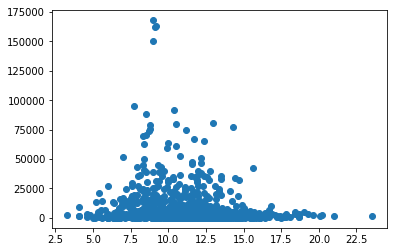

In [27]:
plt.scatter(df3['diabetes'], df3['access_count'])
plt.show()